In [115]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,ElasticNet,Ridge,Lasso
from sklearn.feature_selection import mutual_info_regression,SelectKBest,f_regression
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_squared_error

In [76]:
bodyfat_bunch = fetch_openml('bodyfat',as_frame=True)

/home/raphael.bouvet@Digital-Grenoble.local/anaconda3/envs/stats_3/lib/python3.9/site-packages/sklearn/datasets/_openml.py:417: UserWarning: Multiple active versions of the dataset matching the name bodyfat exist. Versions may be fundamentally different, returning version 1.
  warn(


In [77]:
df_bodyfat = pd.DataFrame(bodyfat_bunch['frame'])

In [78]:
df_bodyfat.describe()

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,class
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,1.055574,44.884921,178.924405,70.148810,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762,19.150794
std,0.019031,12.602040,29.389160,3.662856,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585,8.368740
min,0.995000,22.000000,118.500000,29.500000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000,0.000000
25%,1.041400,35.750000,159.000000,68.250000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000,12.475000
50%,1.054900,43.000000,176.500000,70.000000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000,19.200000
75%,1.070400,54.000000,197.000000,72.250000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000,25.300000
max,1.108900,81.000000,363.150000,77.750000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000,47.500000


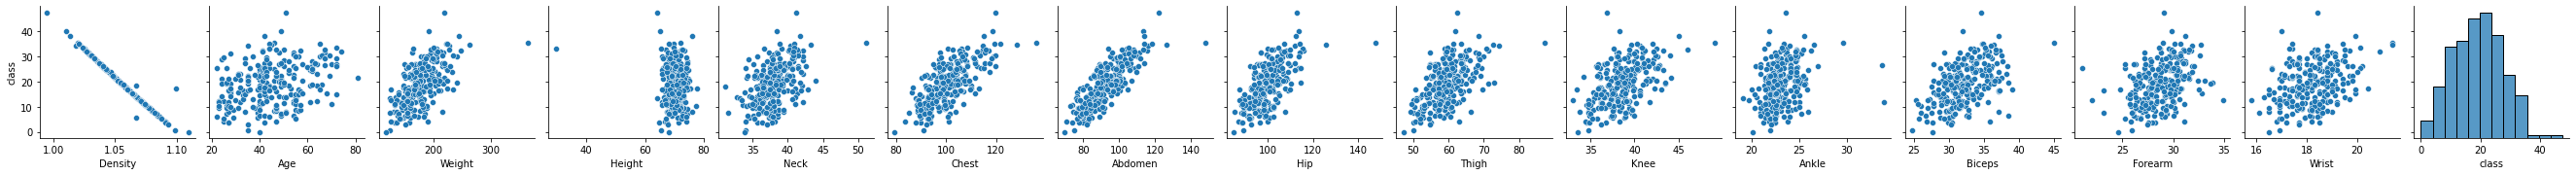

In [79]:
sns.pairplot(df_bodyfat,y_vars='class')

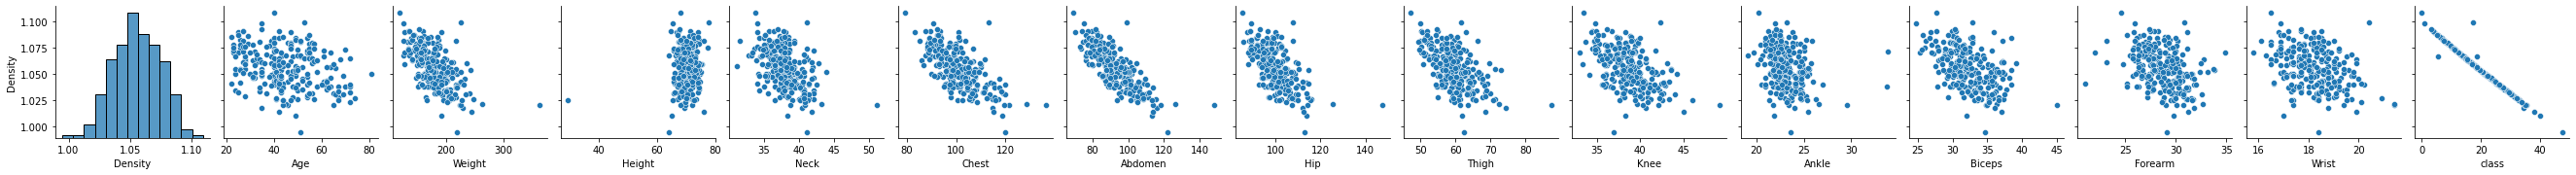

In [80]:
sns.pairplot(df_bodyfat,y_vars='Density')

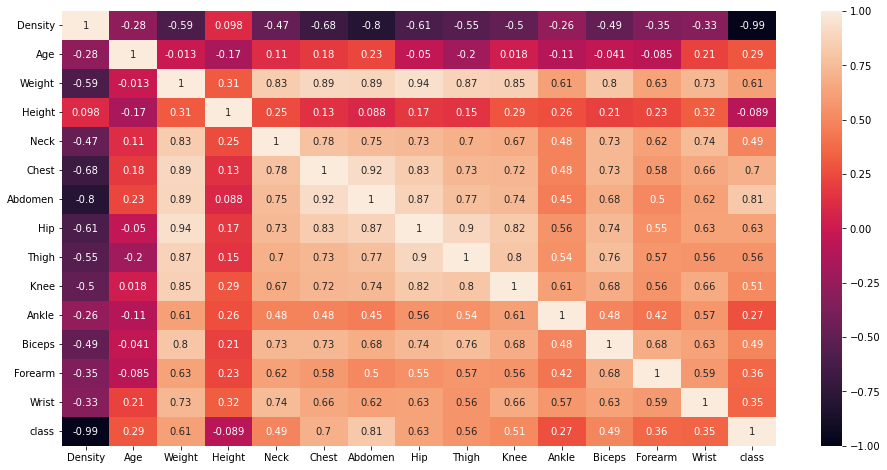

In [81]:
fig,ax =plt.subplots(figsize=(16,8))
ax = sns.heatmap(df_bodyfat.corr(),annot=True,vmin=-1,vmax=1,);

# Preparation test,train  
On cherche a prédire density a partir des autres variables (-class)

In [82]:
density = df_bodyfat['Density']
predictor = df_bodyfat.drop(['Density','class'],axis=1)

In [100]:
density.agg(['mean','std'])

mean    1.055574
std     0.019031
Name: Density, dtype: float64

In [83]:
predictor_train,predictor_test,density_train,density_test = train_test_split(predictor,density)

# Preparation pipelines

In [99]:
model_1 = Ridge(max_iter=10000)
model_2 = Lasso(max_iter=10000)
model_3 = ElasticNet(max_iter=10000)
model_4 = LinearRegression()

scaler_1 = StandardScaler()
scaler_2 = MinMaxScaler()
scaler_3 = Normalizer()
scaler_4 = 'passthrough'

selector_1 = SelectKBest(mutual_info_regression,k='all')
selector_2 = SelectKBest(f_regression,k='all')

liste_scaler = ['passthrough',scaler_1,scaler_2,scaler_3]
liste_selector = [selector_1,selector_2]

nb_col = [i for i in range(1,14)]
alpha = [0.001,0.01,0.1,1,10,100,1000]
l1 = np.arange(0.1,1,0.1)

param_1 = {
    'scaler':liste_scaler,
    'selector__k':nb_col,
    'selector':liste_selector,
    'model__alpha': alpha,
    'model':[model_1]
}

param_2 = {
    'scaler':liste_scaler,
    'selector__k':nb_col,
    'selector':liste_selector,
    'model__alpha': alpha,
    'model':[model_2]
}

param_3 = {
    'scaler':liste_scaler,
    'selector__k' : nb_col,
    'selector':liste_selector,
    'model__alpha' : alpha,
    'model__l1_ratio' :l1,
    'model':[model_3]}

param_4 = {
    'scaler':liste_scaler,
    'selector__k' :nb_col,
    'selector':liste_selector,
    'model':[model_4]}

pipe = Pipeline(steps=[("scaler", scaler_1), 
                       ("selector", selector_1), 
                       ("model", model_1)])

params = [param_1,param_2,param_3,param_4]

In [107]:
grid_search = GridSearchCV(pipe,params,cv=10,scoring='neg_mean_squared_error')

In [108]:
grid_search.fit(predictor_train,density_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector',
                                        SelectKBest(k='all',
                                                    score_func=<function mutual_info_regression at 0x7fe8175ab5e0>)),
                                       ('model',
                                        Ridge(alpha=0.1, max_iter=10000))]),
             param_grid=[{'model': [Ridge(alpha=0.1, max_iter=10000)],
                          'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'scaler': ['passthrough', StandardScaler...
                          'selector__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13]},
                         {'model': [LinearRegression()],
                          'scaler': ['passthrough', StandardScaler(),
                                     MinMaxScaler(), Normalizer()],
         

In [111]:
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results['RMSE_train'] = np.sqrt(-grid_results['mean_test_score'])
grid_results.sort_values('RMSE_train')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__alpha,param_scaler,param_selector,param_selector__k,param_model__l1_ratio,...,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,RMSE_train
1504,0.002672,0.000041,0.001069,0.000101,"ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter...",0.001,StandardScaler(),SelectKBest(score_func=<function f_regression ...,10,0.1,...,-0.000089,-0.000076,-0.000112,-0.000067,-0.000099,-0.000048,-0.000095,0.000026,1,0.009728
360,0.002713,0.000167,0.001034,0.000043,"Ridge(alpha=0.1, max_iter=10000)",1,StandardScaler(),SelectKBest(score_func=<function f_regression ...,10,NaN,...,-0.000090,-0.000076,-0.000117,-0.000071,-0.000099,-0.000049,-0.000095,0.000024,2,0.009741
178,0.002973,0.000600,0.001169,0.000182,"Ridge(alpha=0.1, max_iter=10000)",0.01,MinMaxScaler(),SelectKBest(score_func=<function f_regression ...,10,NaN,...,-0.000091,-0.000075,-0.000117,-0.000071,-0.000100,-0.000051,-0.000095,0.000024,3,0.009741
1582,0.002559,0.000017,0.001006,0.000003,"ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter...",0.001,passthrough,SelectKBest(score_func=<function f_regression ...,10,0.2,...,-0.000092,-0.000080,-0.000116,-0.000071,-0.000098,-0.000052,-0.000095,0.000023,4,0.009749
1478,0.002433,0.000014,0.000959,0.000009,"ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter...",0.001,passthrough,SelectKBest(score_func=<function f_regression ...,10,0.1,...,-0.000093,-0.000078,-0.000117,-0.000071,-0.000099,-0.000052,-0.000095,0.000023,5,0.009750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4348,0.016037,0.000255,0.001084,0.000021,"ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter...",1,Normalizer(),"SelectKBest(k='all',\n score_func=<...",7,0.1,...,-0.000312,-0.000351,-0.000391,-0.000322,-0.000313,-0.000195,-0.000335,0.000065,2644,0.018299
4347,0.015947,0.000243,0.001076,0.000017,"ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter...",1,Normalizer(),"SelectKBest(k='all',\n score_func=<...",6,0.1,...,-0.000312,-0.000351,-0.000391,-0.000322,-0.000313,-0.000195,-0.000335,0.000065,2644,0.018299
4346,0.016311,0.000829,0.001152,0.000188,"ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter...",1,Normalizer(),"SelectKBest(k='all',\n score_func=<...",5,0.1,...,-0.000312,-0.000351,-0.000391,-0.000322,-0.000313,-0.000195,-0.000335,0.000065,2644,0.018299
4354,0.015978,0.000222,0.001095,0.000044,"ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter...",1,Normalizer(),"SelectKBest(k='all',\n score_func=<...",13,0.1,...,-0.000312,-0.000351,-0.000391,-0.000322,-0.000313,-0.000195,-0.000335,0.000065,2644,0.018299


In [125]:
grid_search

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector',
                                        SelectKBest(k='all',
                                                    score_func=<function mutual_info_regression at 0x7fe8175ab5e0>)),
                                       ('model',
                                        Ridge(alpha=0.1, max_iter=10000))]),
             param_grid=[{'model': [Ridge(alpha=0.1, max_iter=10000)],
                          'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'scaler': ['passthrough', StandardScaler...
                          'selector__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13]},
                         {'model': [LinearRegression()],
                          'scaler': ['passthrough', StandardScaler(),
                                     MinMaxScaler(), Normalizer()],
         

In [122]:
grid_search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('selector',
                 SelectKBest(score_func=<function f_regression at 0x7fe81786e8b0>)),
                ('model',
                 ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter=10000))])

In [121]:
best_pipe = grid_search.best_estimator_

In [113]:
predicted = best_pipe.predict(predictor_test)

In [117]:
best_pipe.score(predictor_test,density_test)

0.6808051171773017

In [116]:
print(np.sqrt(mean_squared_error(density_test,predicted)))

0.011734903711401639
